In [1]:
import keras
import pickle
import numpy as np
import pandas as pd
import tensorflow as tf
from tqdm import tqdm_notebook
from utils.sentence_processor import SentenceProcessor
from utils.stop_words import stop_words

Using TensorFlow backend.
C:\Users\miair\Anaconda3\envs\tensorflow\lib\site-packages\gensim\utils.py:865: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


In [64]:
import importlib
import utils.sentence_processor
importlib.reload(utils.sentence_processor)

<module 'utils.sentence_processor' from 'C:\\Users\\miair\\Documents\\Python Scripts\\sent_analysis\\MVideo\\utils\\sentence_processor.py'>

### Загрузка данных

Для начала загружаем данные из \*.csv файлов, данные были предварительно разбиты на обучающую и проверочную выборки (см. файл "data preprocessing.ipynb"). Кроме того, были загружены дополнительные данные для увеличения обучающей выборки(отзывы об интернет провайдерах).

In [2]:
# загрузка из файла
reviews_test = pd.read_csv('data/reviews_test.csv', header=0, encoding='utf-8')
reviews_train = pd.read_csv('data/reviews_train.csv', header=0, encoding='utf-8')
reviews_internet = pd.read_csv('data/internet_reviews.csv', header=0, encoding='utf-8')

# обучающая выборка
X_train_raw = reviews_train.comment
y_train_raw = reviews_train.reting

# проверочная выборка
X_test_raw = reviews_test.comment
y_test_raw = reviews_test.reting

# дополнительная обучающая выборка
X_internet = reviews_internet.comment
y_internet = reviews_internet.rating

#### Загрузка обработчика комментариев

Загружаем предобученную модель word to vec в обработчик комментариев (модель можно найти [здесь](https://www.nlpub.ru/Russian_Distributional_Thesaurus), мы использовали модель размерностью 500 со словарем более 1 млн. слов).
<br /><br />В обработчике:
 - переводим текст в нижний регистр
 - разбиваем по словам, удаляя всё, кроме букв
 - исправляем орфографию, где это возможно, с помощью [Яндекс.спеллер](https://tech.yandex.ru/speller/)
 - нормализуем слова, приводя их к единственному числу, именительному падежу и т.д. и т.п.
 - еще раз иcправляем орфографию :)
 - переводим полученный массив слов с помощью обученной w2v модели в матрицу размерностью количество\_слов х размер\_вектора\_слова - 100x500 (размер комментария выбран изходя из анализа данных в  "data preprocessing.ipynb")

In [3]:
DIR = 'data/w2v_models/'
MODEL_NAME = 'tenth.norm-sz500-w7-cb0-it5-min5.w2v'
#MODEL_NAME = 'all.norm-sz100-w10-cb0-it1-min100.w2v'

In [4]:
# initialazing comment preprocessor
sp = SentenceProcessor(DIR + MODEL_NAME)
sp.stop_list = stop_words
sp.sample_len = 100

In [5]:
WORD_VECTOR_LENGTH = sp.w2v.vector_size # 500 each word
SENTENCE_LENGTH = sp.sample_len # 100 words

print ('Размерность коментария: {}x{}'.format(SENTENCE_LENGTH, WORD_VECTOR_LENGTH))

Размерность коментария: 100x500


#### Обработка данных

In [ ]:
# приводим оба датафрема к одному формату
del reviews_internet['Unnamed: 0']
reviews_internet = reviews_internet.rename(columns={'rating':'reting'})

# склеиваем данные
new_reviews = reviews_train.append(reviews_internet, ignore_index=True)

# добавляем новый столбец
new_reviews['bag_of_words'] = ' '

In [ ]:
# первичная предобработка данных(токенизация, нормализация, исправление орфографических ошибок)
bag_of_bags = []
for i in tqdm_notebook(range(len(new_reviews.comment))):
    bag_of_bags.append(' '.join(sp.process(new_reviews.comment[i])))

In [ ]:
# добавляем обработанные комментарии в новый столбец
new_reviews['bag_of_words'] = bag_of_bags

# сохраняем наши данные в .csv формате
new_reviews.to_csv('data/new_reviews.csv')

# на всякий случай сохраняем обработанные комментарии в .pkl
with open('bag_{}.pkl'.format(len(bag_of_bags)), 'wb') as f:
    pickle.dump(bag_of_bags, f)

In [6]:
# читаем из файла если предыдущие шаги уже выполнены
new_reviews = pd.read_csv('data/new_reviews.csv', encoding='cp1251')

In [22]:
# полная обучающая выборка
X_train_all = new_reviews.bag_of_words
y_train_all = new_reviews.reting

# обучающая выборка от МВидео (без дополнительных отзывов об интернет провайдерах)
X_train = new_reviews.bag_of_words[:12410]
y_train = new_reviews.reting[:12410]

# тестовая выборка
X_val = reviews_test.comment
y_val = reviews_test.reting

In [8]:
from utils.generators import train_generator, test_generator
from keras.regularizers import l2 as L2
l2 = L2(0.01)

In [9]:
MODELS_DIR = 'data/nn_models/'

# Модель № 1
**Вход**

**Данные:** Данные предоставленные МВидео (80% обучающая выборка/ 20% тестовая выборка)

**Представление:** word2vec на основе обученной модели gensim, размерность пространства: 500

**Описание модели:** 4 параллельные 1D свертки с разым размером окна по компоненте word2vec, с L2 регулиризацией, далее объединение результатов, GlobalVaxPooling, и один полносвязный слой с дропаутом, далее выход регрессии.

**Параметры обучения:** Оптимизатор: стохастический градиентный спуск, learning rate опредлялся как: 2 эпохи с 0.01, далее ~5 эпох с 0.001, далее ~5 эпох с 0.0001, далее ~5 эпох с 0.00005

**Целевая метрика:** MSE

**Результат:** MSE(train)=0.8403, MSE(test)=**0.9136**

In [53]:
# создаем модель нейросети
input = keras.layers.Input(shape=(SENTENCE_LENGTH, WORD_VECTOR_LENGTH))
l_0 = keras.layers.Dense(256)(input)
l_1 = keras.layers.Conv1D(nb_filter=256, filter_length=2, activation='relu', W_regularizer=l2)(input)
l_2 = keras.layers.Conv1D(nb_filter=256, filter_length=3, activation='relu', W_regularizer=l2)(input)
l_3 = keras.layers.Conv1D(nb_filter=256, filter_length=4, activation='relu', W_regularizer=l2)(input)
merge = keras.layers.Merge(mode='concat', concat_axis=1) ([l_0, l_1, l_2, l_3])
l_5 = keras.layers.GlobalMaxPooling1D()(merge)
l_6 = keras.layers.Dropout(0.5)(l_5)
output = keras.layers.Dense(1, activation=None, W_regularizer=l2)(l_6)
model = keras.models.Model(input, output, name='model_5')
model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_2 (InputLayer)             (None, 100, 500)      0                                            
____________________________________________________________________________________________________
dense_2 (Dense)                  (None, 100, 256)      128256      input_2[0][0]                    
____________________________________________________________________________________________________
convolution1d_1 (Convolution1D)  (None, 99, 256)       256256      input_2[0][0]                    
____________________________________________________________________________________________________
convolution1d_2 (Convolution1D)  (None, 98, 256)       384256      input_2[0][0]                    
___________________________________________________________________________________________

In [74]:
# загрузка обученной модели
model = keras.models.load_model('data/nn_models/model_5_mse_0.9056_extra')

In [ ]:
# обучение
optimizer = keras.optimizers.SGD(lr=0.01)
model.compile(loss='mean_squared_error', optimizer=optimizer, metrics=['mse'])

model.fit_generator(
    train_generator(X_train, y_train, sp, shuffle=True), 
    nb_epoch=10,
    samples_per_epoch=len(y_train),
    validation_data=train_generator(X_val, y_val, sp, shuffle=False),
    nb_val_samples=len(y_val),
    verbose=2,
)

In [79]:
# сохранение обчунной модели
model.save('data/nn_models/trained_model_1(keras==1.2.2)')

## Результаты

mode 
MSE: 0.9136
MAE: 0.6817
MedianAE: 0.4942
R2 score: 0.471


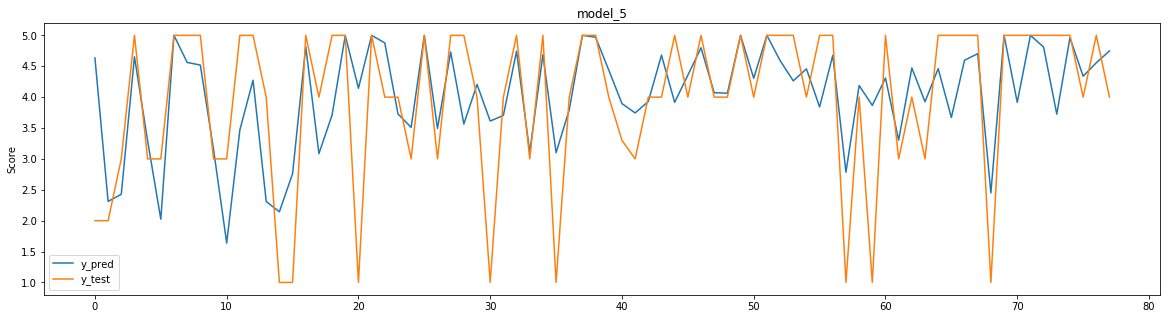

In [78]:
# метрики
errors = get_score(model, X_val_vec, y_val.values, sparse=40)

### Классификатор 5 / не 5

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score

In [34]:
def to_bool(y):
    y_bool = []
    for a in y:
        if a == 5.0:
            y_bool.append(1)
        else:
            y_bool.append(0)
    return y_bool

y_train_bool = to_bool(y_train)
y_test_bool = to_bool(y_test)  

Cнизижаем размерность

In [6]:
p = PCA(n_components=100)

In [7]:
p.fit(X_train.reshape((X_train.shape[0], -1)))

PCA(copy=True, iterated_power='auto', n_components=100, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

In [10]:
X_train_transformed = p.transform(X_train.reshape((X_train.shape[0], -1)))

In [8]:
X_test_transformed = p.transform(X_test.reshape((X_test.shape[0], -1)))

Обучаем классификатор

In [28]:
clf = SVC(C=100.0)
clf.fit(X_train_transformed, y_train_bool)

SVC(C=100.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [29]:
y_pred = clf.predict(X_test_transformed)

In [35]:
accuracy_score(y_test_bool, y_pred)

0.66720464816010328